# Практика по проверке АБ-тестов. <br/>
Цель: Используя данные https://www.kaggle.com/zhangluyuan/ab-testing провести анализ ab-теста на различие в двух выборках

In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('ab_data.csv', header = 0)
data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


Судя по всему, treatment группе должны были показывать новую страницу, а контрольной группе - старую. Проверим, есть ли исключения.

In [4]:
data[(data.group == 'control') & (data.landing_page == 'new_page')]

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1
...,...,...,...,...,...
293894,741581,2017-01-09 20:49:03.391764,control,new_page,0
293996,942612,2017-01-08 13:52:28.182648,control,new_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


In [5]:
data[(data.group == 'treatment') & (data.landing_page == 'old_page')]

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


По сравнению с общим количеством данных число выбросов (участники группы посмотрели "не свои" страницы) невелико, поэтому просто удалим их.

In [6]:
data.drop(data[(data.group == 'control') & (data.landing_page == 'new_page')].index, inplace=True)
data.drop(data[(data.group == 'treatment') & (data.landing_page == 'old_page')].index, inplace=True)

Посмотрим на наши данные

In [7]:
data[(data.landing_page=='old_page') & (data.converted == 0)]

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
16,847721,2017-01-17 14:01:00.090575,control,old_page,0
...,...,...,...,...,...
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0


In [8]:
data[(data.landing_page=='old_page') & (data.converted == 1)]

,user_id,timestamp,group,landing_page,converted
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
15,644214,2017-01-22 02:05:21.719434,control,old_page,1
28,913579,2017-01-24 09:11:39.164256,control,old_page,1
36,831737,2017-01-11 21:18:20.911015,control,old_page,1
43,862225,2017-01-08 14:49:37.335432,control,old_page,1
...,...,...,...,...,...
294383,728029,2017-01-11 11:17:05.291493,control,old_page,1
294385,850065,2017-01-17 11:57:18.569907,control,old_page,1
294405,712217,2017-01-11 10:34:30.176801,control,old_page,1
294420,795742,2017-01-09 01:06:58.299207,control,old_page,1


Введем следующие переменные: <br/>
*old_1* - число converted=1 для old_page<br/>
*new_1* - число converted=1 для new_page<br/>
*old_cnt* - число просмотренных old_page<br/>
*new_cnt* - число просмотренных new_page<br/>

In [9]:
old_1 = len(data[(data.landing_page=='old_page') & (data.converted == 1)])
old_1
old_cnt = len(data[data.landing_page=='old_page'])
old_cnt

145274

In [10]:
new_1 = len(data[(data.landing_page=='new_page') & (data.converted == 1)])
new_1
new_cnt = len(data[data.landing_page=='new_page'])
new_cnt

145311

In [11]:
Pold = old_1 / old_cnt
print('Доля converted среди просмотренных старых страниц', Pold)

Доля converted среди просмотренных старых страниц 0.1203863045004612


In [12]:
Pnew = new_1/new_cnt
print('Доля converted среди просмотренных новых страниц', Pnew)

Доля converted среди просмотренных новых страниц 0.11880724790277405


Таким образом, вероятности converted для старой страницы - 12.0386% и для новой страницы - 11.8807%. 

Рассмотрим следующие нулевую и альтернативную гипотезы:

$$ H_0: P_{old} >= P_{new} $$
$$ H_1: P_{old} < P_{new} $$

Построим доверительный интервал для разности долей

In [13]:
alpha = 0.05
z = scipy.stats.norm.ppf(1 - alpha / 2.)
left_boundary = (Pold - Pnew) - z * np.sqrt(Pold * (1 - Pold)/ old_cnt + Pnew * (1 - Pnew)/ new_cnt)
right_boundary = (Pold - Pnew) + z * np.sqrt(Pold * (1 - Pold)/ old_cnt + Pnew * (1 - Pnew)/ new_cnt)
print("95%% confidence interval for a difference between proportions: [%f, %f]" % (left_boundary, right_boundary))

95% confidence interval for a difference between proportions: [-0.000781, 0.003939]


In [14]:
# Считаем z оценку
P = float(Pold*old_cnt + Pnew*new_cnt) / (old_cnt + new_cnt)
z_stat = (Pold - Pnew) / np.sqrt(P * (1 - P) * (1. / old_cnt + 1. / new_cnt))
z_stat

1.3116075339133115

In [15]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [16]:
print ("p-value: %f" % proportions_diff_z_test(z_stat))

p-value: 0.189653


In [17]:
print ("p-value: %f" % proportions_diff_z_test(z_stat, 'less'))

p-value: 0.905174


In [18]:
print ("p-value: %f" % proportions_diff_z_test(z_stat, 'greater'))

p-value: 0.094826


Ноль входит в доверительный интервал и значения p-value достаточно большие (больше 0.05 -обычно выбираемый alpha level), поэтому мы не можем опровергнуть нулевую гипотезу. 

Проведем __randomized test__ по следующему алгоритму ("Практическая статистика для data science")

1. Create an urn with all sample results
2. Shuffle and draw out a resample of size old_cnt, and record how many 1s.
3. Record the number of 1s in the remaining new_cnt samples.
4. Record the difference in proportion 1s.
5. Repeat steps 2–4.
6. How often was the difference >= (Pold-Pnew)?

In [19]:
new_urn = np.zeros(old_cnt+new_cnt)

In [20]:
new_urn[:old_1+new_1] = 1

Проверим, что в массиве действительно 34753 единицы.

In [21]:
np.sum(new_urn)

34753.0

In [22]:
diffs = []

In [23]:
for _ in range(10000):
    np.random.shuffle(new_urn)
    urn_old_1 = np.sum(new_urn[:old_cnt])
    urn_new_1 = np.sum(new_urn[old_cnt:])
    diffs.append((urn_old_1 / old_cnt) - (urn_new_1 / new_cnt))
    

In [24]:
diff = Pold-Pnew
diff

0.0015790565976871451

Построим гистограмму разниц между группами, полученными в результате resampling. 

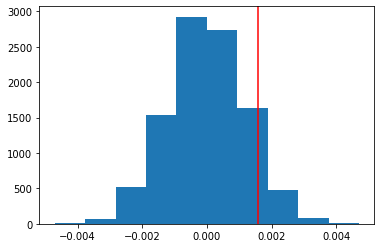

In [25]:
diffs = np.array(diffs)
plt.hist(diffs);
plt.axvline(x=diff,color ='red')

Посчитаем, сколько раз в наших тестах разница была больше, чем Pold-Pnew

In [26]:
len(np.where(diffs > diff)[0])

935

По определению __p-value is the frequency with which the chance model produces a result more extreme than the observed result__.<br/> Посчитаем отношение случаев справа от красной линии на гистограмме к числу проведенных randomized test (в нашем случае 10000).

In [27]:
p_val = len(np.where(diffs > diff)[0]) /10000
p_val

0.0935

Посчитаем отношение случаев слева от красной линии на гистограмме к числу проведенных тестов (10000).

In [28]:
p_val = (len(diffs) - len(np.where(diffs > diff)[0])) /10000
p_val

0.9065

**Нулевая гипотеза не может быть отвергнута.**